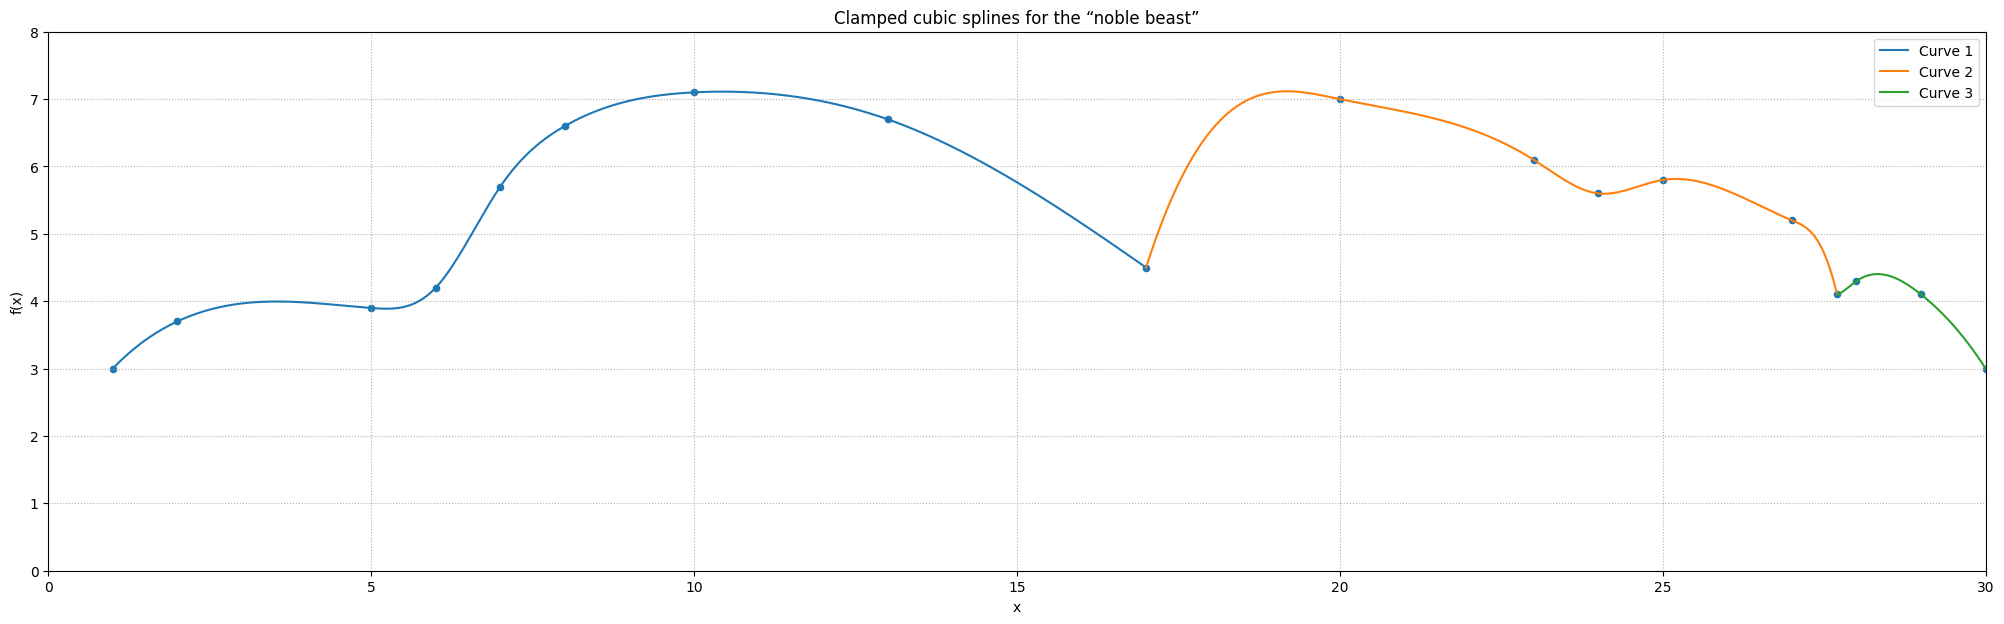

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def clamped_cubic_spline(x, a, fp0, fpn):
    x = np.asarray(x, dtype=float)
    a = np.asarray(a, dtype=float)
    n = len(x) - 1
    h = np.diff(x)

    alpha = np.zeros(n + 1)
    alpha[0] = 3*(a[1] - a[0]) / h[0] - 3*fp0
    alpha[n] = 3*fpn - 3*(a[n] - a[n-1]) / h[n-1]
    for i in range(1, n):
        alpha[i] = 3/h[i] * (a[i+1] - a[i]) - 3/h[i-1] * (a[i] - a[i-1])

    l  = np.zeros(n + 1)
    mu = np.zeros(n + 1)
    z  = np.zeros(n + 1)

    l[0] = 2*h[0]
    mu[0] = 0.5
    z[0]  = alpha[0] / l[0]

    for i in range(1, n):
        l[i]  = 2*(x[i+1] - x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i]  = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    l[n] = h[n-1]*(2 - mu[n-1])
    z[n] = (alpha[n] - h[n-1]*z[n-1]) / l[n]

    c = np.zeros(n + 1)
    b = np.zeros(n)
    d = np.zeros(n)
    c[n] = z[n]

    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1] - a[j]) / h[j] - h[j]*(c[j+1] + 2*c[j]) / 3
        d[j] = (c[j+1] - c[j]) / (3*h[j])

    return a[:-1], b, c[:-1], d   

x1  = np.array([1, 2, 5, 6, 7, 8, 10, 13, 17], dtype=float)
y1  = np.array([3.0, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5], dtype=float)
fp1_start, fp1_end = 1.0, -0.67

x2  = np.array([17, 20, 23, 24, 25, 27, 27.7], dtype=float)
y2  = np.array([4.5, 7.0, 6.1, 5.6, 5.8, 5.2, 4.1], dtype=float)
fp2_start, fp2_end = 3.0, -4.0

x3  = np.array([27.7, 28, 29, 30], dtype=float)
y3  = np.array([4.1, 4.3, 4.1, 3.0], dtype=float)
fp3_start, fp3_end = 0.33, -1.5


a1, b1, c1, d1 = clamped_cubic_spline(x1, y1, fp1_start, fp1_end)
a2, b2, c2, d2 = clamped_cubic_spline(x2, y2, fp2_start, fp2_end)
a3, b3, c3, d3 = clamped_cubic_spline(x3, y3, fp3_start, fp3_end)

def make_df(x, a, b, c, d):
    return pd.DataFrame(
        {
            "interval": [f"[{x[i]}, {x[i+1]}]" for i in range(len(a))],
            "a": a, "b": b, "c": c, "d": d
        }
    ).set_index("interval").round(6)



def eval_spline(x_nodes, a, b, c, d, num=200):
    """Return dense (x, y) values for plotting a piecewise cubic spline."""
    xs_dense = []
    ys_dense = []
    for j in range(len(a)):
        xs = np.linspace(x_nodes[j], x_nodes[j+1], num)
        ys = a[j] + b[j]*(xs - x_nodes[j]) + c[j]*(xs - x_nodes[j])**2 + d[j]*(xs - x_nodes[j])**3
        xs_dense.append(xs)
        ys_dense.append(ys)
    return np.concatenate(xs_dense), np.concatenate(ys_dense)

x_dense_1, y_dense_1 = eval_spline(x1, a1, b1, c1, d1)
x_dense_2, y_dense_2 = eval_spline(x2, a2, b2, c2, d2)
x_dense_3, y_dense_3 = eval_spline(x3, a3, b3, c3, d3)

plt.figure(figsize=(25, 7)) 
plt.plot(x_dense_1, y_dense_1, label="Curve 1") 
plt.plot(x_dense_2, y_dense_2, label="Curve 2")
plt.plot(x_dense_3, y_dense_3, label="Curve 3")

plt.scatter(np.r_[x1, x2[1:], x3[1:]], np.r_[y1, y2[1:], y3[1:]], s=20, marker="o")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Clamped cubic splines for the “noble beast”")
plt.grid(True, linestyle=":")
plt.legend()
plt.xlim(0, 30)
plt.ylim(0, 8)
plt.show()



Curve 1 (natural spline) coefficients
interval         a         b         c         d
  [1, 2]  3.000000  0.785704  0.000000 -0.085704
  [2, 5]  3.700000  0.528591 -0.257113  0.034379
  [5, 6]  3.900000 -0.085843  0.052302  0.333540
  [6, 7]  4.200000  1.019383  1.052923 -0.572306
  [7, 8]  5.700000  1.408311 -0.663996  0.155685
 [8, 10]  6.600000  0.547374 -0.196940  0.024127
[10, 13]  7.100000  0.049132 -0.052181 -0.002880
[13, 17]  6.700000 -0.341722 -0.078104  0.006509

Curve 2 (natural spline) coefficients
  interval         a         b         c         d
  [17, 20]  4.500000  1.105734  0.000000 -0.030267
  [20, 23]  7.000000  0.288531 -0.272401  0.025408
  [23, 24]  6.100000 -0.659859 -0.043729  0.203589
  [24, 25]  5.600000 -0.136552  0.567036 -0.230484
  [25, 27]  5.800000  0.306068 -0.124416 -0.089309
[27, 27.7]  5.200000 -1.263303 -0.660269  0.314414

Curve 3 (natural spline) coefficients
  interval         a         b         c         d
[27.7, 28]  4.100000  0.748582  0.

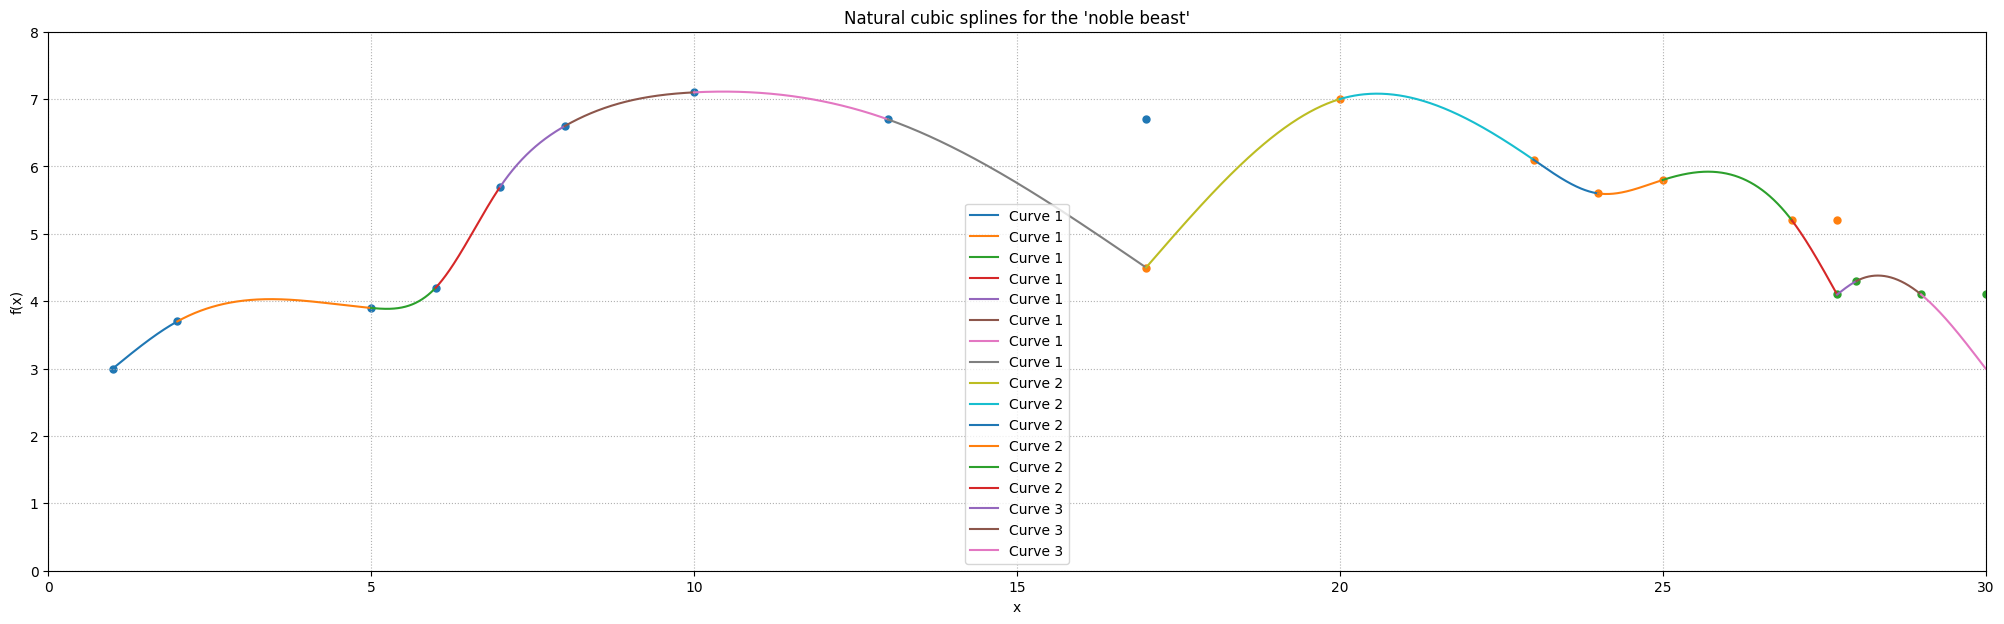

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def natural_cubic_spline(x, a):
    x = np.asarray(x, dtype=float)
    a = np.asarray(a, dtype=float)
    n = len(x) - 1
    h = np.diff(x)

    alpha = np.zeros(n + 1)
    for i in range(1, n):
        alpha[i] = 3/h[i] * (a[i+1] - a[i]) - 3/h[i-1] * (a[i] - a[i-1])

    l = np.ones(n + 1)  
    mu = np.zeros(n + 1)
    z = np.zeros(n + 1)

    for i in range(1, n):
        l[i] = 2*(x[i+1] - x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    c = np.zeros(n + 1)
    b = np.zeros(n)
    d = np.zeros(n)

    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1] - a[j]) / h[j] - h[j]*(c[j+1] + 2*c[j]) / 3
        d[j] = (c[j+1] - c[j]) / (3*h[j])

    return a[:-1], b, c[:-1], d        

x1 = [1, 2, 5, 6, 7, 8, 10, 13, 17]
y1 = [3.0, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5]
x2 = [17, 20, 23, 24, 25, 27, 27.7]
y2 = [4.5, 7.0, 6.1, 5.6, 5.8, 5.2, 4.1]
x3 = [27.7, 28, 29, 30]
y3 = [4.1, 4.3, 4.1, 3.0]

a1, b1, c1, d1 = natural_cubic_spline(x1, y1)
a2, b2, c2, d2 = natural_cubic_spline(x2, y2)
a3, b3, c3, d3 = natural_cubic_spline(x3, y3)

def show_table(name, x, a, b, c, d):
    df = pd.DataFrame({
        "interval": [f"[{x[i]}, {x[i+1]}]" for i in range(len(a))],
        "a": a, "b": b, "c": c, "d": d
    })
    print(f"\n{name} (natural spline) coefficients")
    print(df.to_string(index=False, float_format=lambda v: f"{v:9.6f}"))

show_table("Curve 1", x1, a1, b1, c1, d1)
show_table("Curve 2", x2, a2, b2, c2, d2)
show_table("Curve 3", x3, a3, b3, c3, d3)

def plot_spline(ax, x, a, b, c, d, label):
    for j in range(len(a)):
        xs = np.linspace(x[j], x[j+1], 200)
        ys = (a[j] + b[j]*(xs - x[j]) +
               c[j]*(xs - x[j])**2 +
               d[j]*(xs - x[j])**3)
        ax.plot(xs, ys, lw=1.5, label=label)
    ax.scatter(x, np.r_[a, a[-1]+b[-1]*0], s=25)
    ax.set_title("Natural Cubic Splines")
    ax.grid(ls=":")

fig, ax = plt.subplots(figsize=(25, 7))
plot_spline(ax, x1, a1, b1, c1, d1, "Curve 1")
plot_spline(ax, x2, a2, b2, c2, d2, "Curve 2")
plot_spline(ax, x3, a3, b3, c3, d3, "Curve 3")

ax.set_xlabel("x")
ax.set_ylabel("f(x)")
plt.xlim(0, 30)
plt.ylim(0, 8)
ax.legend()
plt.title("Natural cubic splines for the 'noble beast'")

plt.savefig("natural_cubic_splines.png", bbox_inches='tight')
plt.show()